In [1]:

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Define the path to  data in Google Drive
train_data_path = '/content/drive/My Drive/Processed/train/'

# Copy data from Drive to local Colab storage for faster processing
!cp -r "$train_data_path" /content/

In [3]:
# Define the path to  data in Google Drive
test_data_path = '/content/drive/My Drive/Processed/val/'

# Copy data from Drive to local Colab storage for faster processing
!cp -r "$test_data_path" /content/

In [4]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.9 MB/s eta 0:00:00


In [5]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 24.7 MB/s eta 0:00:00


In [6]:
import numpy as np
import pandas as pd
from pathlib import Path
import pydicom
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import torchmetrics
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score

In [7]:
torch.manual_seed(42)

In [8]:
labels = pd.read_csv("/content/drive/MyDrive/stage_2_train_labels.csv")
# Remove duplicate entries
labels = labels.drop_duplicates("patientId")

In [9]:
labels.head(5)[['patientId', 'Target']]  # Checking the sample Label .'Target' is the label

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [10]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(0.49, 0.248),  # Use mean and std from preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1),antialias=True)

])

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize([0.49], [0.248]),  # Use mean and std from preprocessing notebook
])



In [12]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [13]:
train_dataset = torchvision.datasets.DatasetFolder(
    "/content/train",
    loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    "/content/val",
    loader=load_file, extensions="npy", transform=val_transforms)

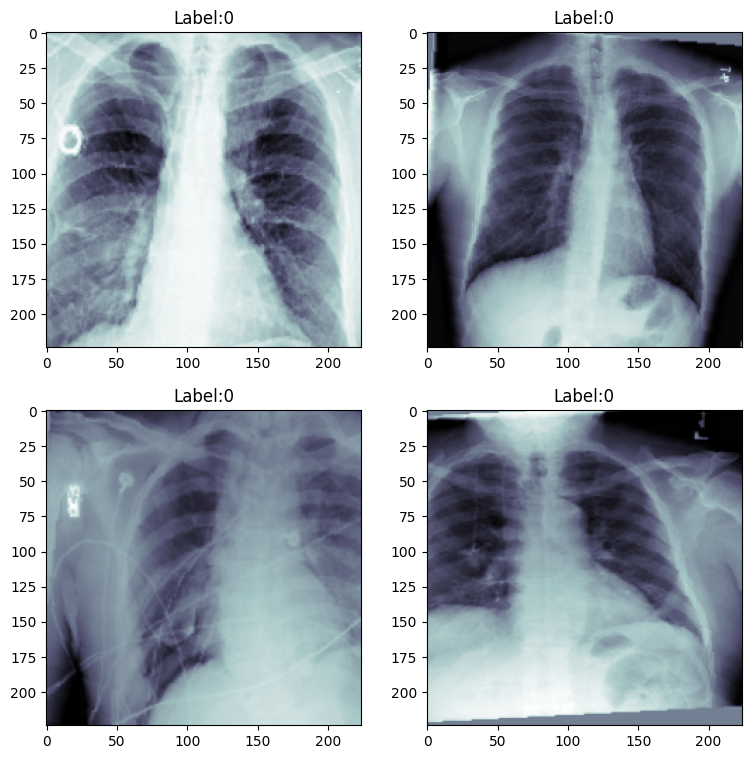

In [14]:
#Visualizing some Samples with their labels
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 20000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")

In [15]:
train_dataset[0][0].shape

torch.Size([1, 224, 224])

In [16]:
batch_size = 512
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 24000 train images and 2684 val images


In [17]:
 import torchvision.models as models

 class CustomNet(nn.Module):
     def __init__(self, num_classes=1):
         super(CustomNet, self).__init__()

         # Load pre-trained ResNet-18
         self.resnet = models.resnet18(weights='DEFAULT')

         # Change the input channel of the first convolution layer to 1 since we are working with greyscale image
         self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
         # Change the output layer for binary classification to 1 for binary classification
         self.resnet.fc = nn.Linear(512, num_classes)  # 'num_classes' should be 1 for binary classification

     def forward(self, x):
         x = self.resnet(x)
         return x


 # Instantiate the custom model using ResNet-18 features
 model = CustomNet()
 print("Custom CNN model using ResNet-18 features defined!")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s]

Custom CNN model using ResNet-18 features defined!


In [18]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)

        target = target.view(-1, 1)  # Reshape to [batch_size, 1]


        # Reset the optimizer
        optimizer.zero_grad()

        # Push the data forward through the model layers
        output = model(data)



        target = target.type_as(output)  # Cast target to the same data type as output

        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()

        # Backpropagate
        loss.backward()
        optimizer.step()

        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print(f'Training set:{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader)} Loss:{loss.item()})')
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [21]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    target_all = []
    predicted_all = []

    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)

            # Get the predicted classes for this batch
            output = model(data)
            outputs = torch.sigmoid(output)
            preds = (outputs > 0.5).float()


            target = target.view(-1, 1)

            target = target.type_as(preds)  # Cast target to the same data type as output

            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()


            # Calculate the accuracy for this batch
            correct += torch.sum(preds == target).item()

             # Append scalar target and predicted values after moving into cpu
            target_all.extend(target.cpu().numpy())
            predicted_all.extend(preds.cpu().numpy())

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count

    # Calculate Precision, Recall, and F1-score using scikit-learn functions
    precision = round(precision_score(target_all, predicted_all, average='weighted'),2)
    recall = round(recall_score(target_all, predicted_all, average='weighted'),2)
    f1 = round(f1_score(target_all, predicted_all, average='weighted'),2)
    precision2 = round(precision_score(target_all, predicted_all, average='binary'),2)
    recall2 = round(recall_score(target_all, predicted_all, average='binary'),2)
    f1_2 = round(f1_score(target_all, predicted_all, average='binary'),2)
    accuracy = round((accuracy_score(target_all, predicted_all)*100),2)
    # Printing the accuracy
    print(f'Validation set: Average loss: {avg_loss},Accuracy: {accuracy}%, Weighted precision:{precision}, Weighted recall:{recall},Weighted f1:{f1}')
    print(f'Positive_class:  precision:{precision2},  recall:{recall2}, f1:{f1_2}')
   # return average loss for the epoch
    return avg_loss,accuracy, precision, recall, f1

In [22]:
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = model.to(device)

# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Specify the loss criteria
loss_criteria = torch.nn.BCEWithLogitsLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []
best_loss = float('inf')  # Initialize with a high value
best_epoch = 0
best_F1 = 0
best_F1_epoch = 0
best_precision = 0
best_precision_epoch = 0
best_recall = 0
best_recall_epoch = 0
best_accuracy = 0
best_accuracy_epoch = 0

# Train over  epochs
epochs = 10
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss, accuracy, precision, recall, f1 = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)
        # Save the model with the lowest validation loss
        if test_loss < best_loss:
          best_loss = test_loss
          best_epoch = epoch
          torch.save(model.state_dict(),'/content/drive/MyDrive/Checkpoint/PneumoniaResnet18.pth')  # Save the best model based on Val loss
        if accuracy > best_accuracy:
          best_accuracy = accuracy
          best_accuracy_epoch = epoch
        if precision > best_precision:
          best_precision = precision
          best_precision_epoch = epoch
        if recall > best_recall:
          best_recall = recall
          best_recall_epoch = epoch
        if f1 > best_F1:
          best_F1 = f1
          best_F1_epoch = epoch
print(f"Best model found at epoch {best_epoch}, with validation loss: {best_loss}")
print(f"Best Accuracy found at epoch {best_accuracy_epoch}, with Accuracy : {best_accuracy}%")
print(f"Best Weighted Precision found at epoch {best_precision_epoch}, with Precision : {best_precision}")
print(f"Best Weighted Recall found at epoch {best_recall_epoch}, with Recall : {best_recall}")
print(f"Best Weighted F1 found at epoch {best_F1_epoch}, with F1 : {best_F1}")

Training on cuda
Epoch: 1
Training set:0/24000 (0.0 Loss:0.3429757356643677)
Training set:5120/24000 (21.27659574468085 Loss:0.34283751249313354)
Training set:10240/24000 (42.5531914893617 Loss:0.44575315713882446)
Training set:15360/24000 (63.829787234042556 Loss:0.3707362711429596)
Training set:20480/24000 (85.1063829787234 Loss:0.31980782747268677)
Training set: Average loss: 0.363893
Validation set: Average loss: 0.3738846282164256,Accuracy: 82.9%, Weighted precision:0.84, Weighted recall:0.83,Weighted f1:0.83
Positive_class:  precision:0.6,  recall:0.71, f1:0.65
Epoch: 2
Training set:0/24000 (0.0 Loss:0.32355061173439026)
Training set:5120/24000 (21.27659574468085 Loss:0.3555026650428772)
Training set:10240/24000 (42.5531914893617 Loss:0.3132462799549103)
Training set:15360/24000 (63.829787234042556 Loss:0.34507298469543457)
Training set:20480/24000 (85.1063829787234 Loss:0.36183494329452515)
Training set: Average loss: 0.351112
Validation set: Average loss: 0.355900543431441,Accu

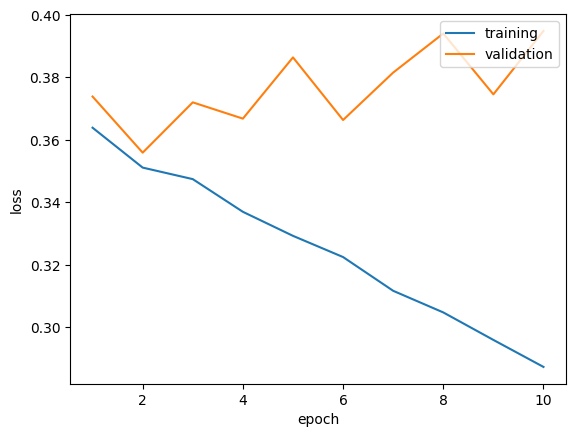

In [23]:
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()